## Models to evaluate
- Logistic Regression
- Naive Bayes
- Random Forest
- LightGBM or XGBoost

In [1]:
import numpy as np
import pandas as pd
#Load dataset
dataset = pd.read_csv("Model B Dataset/healthFactors_dataset_with_indicator.csv")

In [5]:
#Define weight multiplier for minority
#Logic : Multiply by reciprocal of ratio of majority data sample to minority
# 27000 : 1536 ~ 17.5

minority_ratio = dataset['Is Minority'].sum() / len(dataset)
print(f"Minority ratio: {minority_ratio:.4f}")
majority_ratio = 1 - minority_ratio
print(f"Majority ratio: {majority_ratio:.4f}")


#Create sample weights for minority data porition
sample_weights = dataset['Is Minority'].apply(lambda x: 10 if x == 1 else 1)
print(sample_weights)


Minority ratio: 0.0530
Majority ratio: 0.9470
0         1
1         1
2         1
3         1
4        10
         ..
28828     1
28829     1
28830     1
28831     1
28832     1
Name: Is Minority, Length: 28833, dtype: int64


## Train models with sample weights

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

#prepare data

#Drop CVD and Is Minority columns for X
X = dataset.drop(['Cardiovascular Disease','Is Minority'], axis=1)
#Extract output variable into Y
Y = dataset['Cardiovascular Disease']

"""
 stratify=Y: performs a stratified split based on the target, preserving the class
 proportions in both train and test—important for imbalanced datasets.
"""

X_train, X_test, Y_train, Y_test, weights_train, weights_test = train_test_split(
    X,
    Y,
    sample_weights,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

## Train models

Training LogisticRegression...
LogisticRegression trained with sample weighting
Evaluating model...
Training Random Forest...


d:\ACADEMY FOLDER\IUT Academics\Semester 6 (3.2)\ML\Hybrid-CVD-Model\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest trained with sample weighting
Evaluating model...
Training XGBoost...


d:\ACADEMY FOLDER\IUT Academics\Semester 6 (3.2)\ML\Hybrid-CVD-Model\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:19:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained with sample weighting
Evaluating model...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11887, number of negative: 11179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 23066, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.627462 -> initscore=0.521346
[LightGBM] [Info] Start training from score 0.521346
LightGBM trained with sample weighting
Evaluating model...


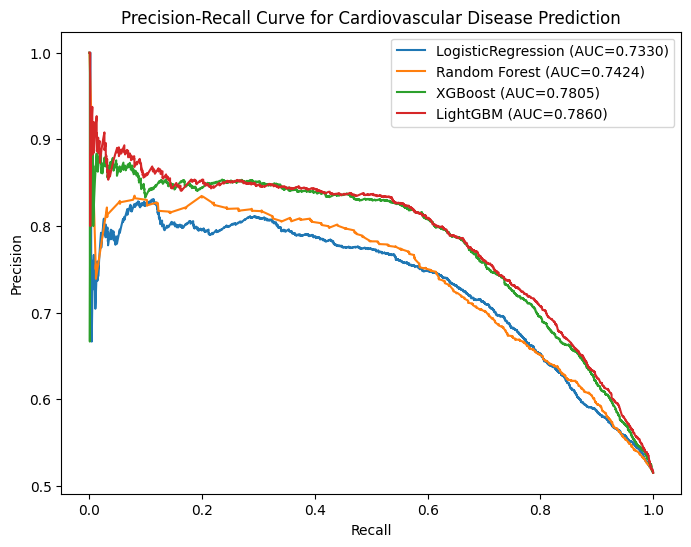

LogisticRegression: Precision-Recall AUC = 0.7330
Random Forest: Precision-Recall AUC = 0.7424
XGBoost: Precision-Recall AUC = 0.7805
LightGBM: Precision-Recall AUC = 0.7860


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

models = {
    'LogisticRegression' : LogisticRegression(),
    'Random Forest' : RandomForestClassifier(n_estimators=100),
    'XGBoost' : xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM' : lgb.LGBMClassifier(objective='binary', random_state=42)
}

results = {}

#Evaluating models
plt.figure(figsize=(8,6))

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, Y_train, sample_weight=weights_train)
    probabilities = model.predict_proba(X_test)[:, 1]
    print(f"{name} trained with sample weighting")
    print("Evaluating model...")
    precision, recall, _ = precision_recall_curve(
        Y_test,
        probabilities,
        pos_label=1,
    )
    pr_auc = auc(recall, precision)
    results[name] = pr_auc
    plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.4f})")





plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Cardiovascular Disease Prediction")
plt.legend()
plt.show()

# Print model performance
for model, score in results.items():
    print(f"{model}: Precision-Recall AUC = {score:.4f}")



## Save models


In [ ]:
import os
import joblib

os.makedirs("saved_models", exist_ok=True)

# scikit-learn models -> joblib
joblib.dump(models['LogisticRegression'], "saved_models/logistic_regression.joblib")
joblib.dump(models['Random Forest'], "saved_models/random_forest.joblib")

# XGBoost -> native format
models['XGBoost'].save_model("saved_models/xgboost_model.json")

# LightGBM -> save underlying Booster (created after fit)
if hasattr(models['LightGBM'], "booster_"):
    models['LightGBM'].booster_.save_model("saved_models/lightgbm_model.txt")
else:
    joblib.dump(models['LightGBM'], "saved_models/lightgbm_model.joblib")

print("Models saved to ./saved_models")

Models saved to ./saved_models


In [11]:
Y_train.shape

(23066,)

In [17]:
# Find optimal threshold based on clinical preference
from sklearn.metrics import precision_recall_curve

# Get 1D positive-class scores
y_scores = models['LightGBM'].predict_proba(X_train)
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

precision, recall, thresholds = precision_recall_curve(
    Y_train,
    y_scores,
    # sample_weight=weights_train,  # optional
)

# thresholds has length len(precision) - 1
prec_t = precision[:-1]
rec_t  = recall[:-1]

# High-precision operating point (minimize false positives)
hp_idx = np.where(prec_t >= 0.80)[0]
if hp_idx.size:
    optimal_threshold_conservative = thresholds[hp_idx[-1]]
else:
    optimal_threshold_conservative = 0.5  # fallback

# Balanced operating point (F1-score maximization)
eps = 1e-12
f1_scores = 2 * prec_t * rec_t / (prec_t + rec_t + eps)
optimal_threshold_balanced = thresholds[np.argmax(f1_scores)]

print("Conservative threshold:", optimal_threshold_conservative)
print("Balanced (F1-max) threshold:", optimal_threshold_balanced)

Conservative threshold: 0.9944828329291302
Balanced (F1-max) threshold: 0.39853573228558997


In [12]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(X_train, Y_train, sample_weight = weights_train, epochs=500)

Epoch 1/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 1.1822
Epoch 2/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 0.9378
Epoch 3/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 0.9524
Epoch 4/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 0.9203
Epoch 5/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 0.9269
Epoch 6/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 0.9082
Epoch 7/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - loss: 0.8981
Epoch 8/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 0.9040
Epoch 9/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - loss: 0.8938
Epoch 10/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - loss: 0.8869
Epoch 11/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - loss: 0.8905
Epoch 12/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - loss: 0.8862
Epoch 13/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - loss: 0.8817
Epoch 14/500
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - loss: 0.8837
Epoch 15/500
72

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step


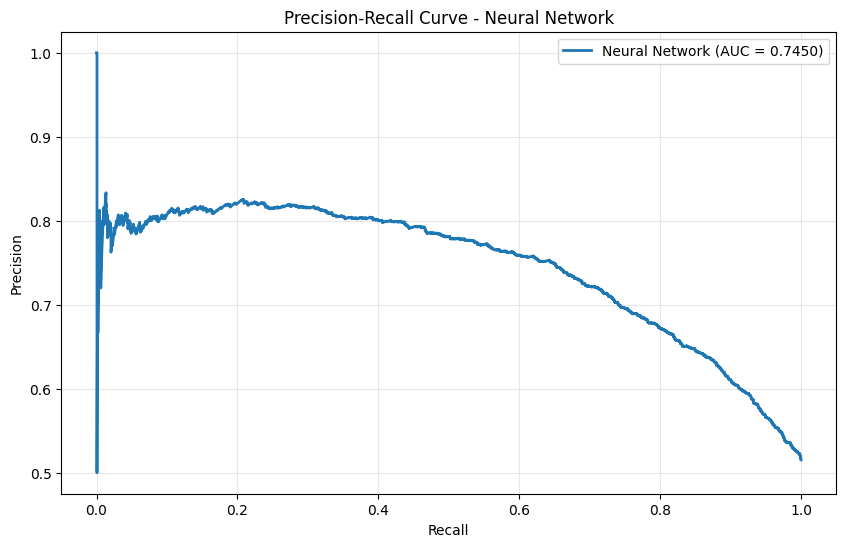

Neural Network PR-AUC: 0.7450


In [13]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Get probability predictions for test set
y_pred_proba_nn = model.predict(X_test).flatten()  # flatten() converts (n,1) to (n,)

# Calculate precision-recall curve
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(Y_test, y_pred_proba_nn)
pr_auc_nn = auc(recall_nn, precision_nn)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_nn, precision_nn, label=f'Neural Network (AUC = {pr_auc_nn:.4f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Neural Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Neural Network PR-AUC: {pr_auc_nn:.4f}")

## Getting Raw probability values

In [16]:
# For any scikit-learn model (LogisticRegression, RandomForest, XGBoost, etc.)
single_patient_data = np.array([[63.0, 26.7, 2, 89.0, 1, 3, 130.0]])

for model_name, model in models.items():
    prob = model.predict_proba(single_patient_data)[0][1]
    print(f"{model_name}: {prob:.4f} ({prob*100:.2f}%)")


LogisticRegression: 0.8536 (85.36%)
Random Forest: 0.9100 (91.00%)
XGBoost: 0.8480 (84.80%)
LightGBM: 0.7781 (77.81%)


d:\ACADEMY FOLDER\IUT Academics\Semester 6 (3.2)\ML\Hybrid-CVD-Model\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
d:\ACADEMY FOLDER\IUT Academics\Semester 6 (3.2)\ML\Hybrid-CVD-Model\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\ACADEMY FOLDER\IUT Academics\Semester 6 (3.2)\ML\Hybrid-CVD-Model\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
